In [2]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime as dt

from sentinelhub import (
    SHConfig,
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest,
    Geometry,
    filter_times,
    MosaickingOrder,
    SentinelHubCatalog
)

import sh_credentials
from utils import plot_image

c:\Users\wjeer\Anaconda3\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [3]:
#Connect to Sentinel Hub
config = SHConfig()

#Use sh_credentials in the config
config.instance_id = sh_credentials.instance_id
config.sh_client_id = sh_credentials.sh_client_id
config.sh_client_secret = sh_credentials.sh_client_secret

In [4]:
#Read in the feedlot sample kml
file_path = "../Data/porcupine_mountains.geojson"
aoi_gdf = gpd.read_file(file_path)

In [5]:
#look at the boundary
aoi_gdf

,geometry
0,"POLYGON ((-89.99725 46.65085, -89.61342 46.650..."


In [6]:
#Make into Sentinelhub geometry object
aoi_geometry = Geometry(aoi_gdf.geometry.values[0], crs = CRS.WGS84)
aoi_geometry

Geometry(POLYGON ((-89.99725341796874 46.6508502096111, -89.61341857910156 46.6508502096111, -89.61341857910156 46.880845705719146, -89.99725341796874 46.880845705719146, -89.99725341796874 46.6508502096111)), crs=CRS('4326'))

In [7]:
#create bbox
resolution = 15
aoi_bbox = aoi_geometry.bbox
aoi_size = bbox_to_dimensions(aoi_bbox, resolution = resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 15 m resolution: (2015, 1634) pixels


In [8]:
#Summer 6/22/22
#Fall 10/18/2021
#winter 1/31/22
#spring 5/01/22

In [9]:
#Setting up the catolog
from time import time_ns

catalog = SentinelHubCatalog(config=config)

#Selecting Time interval
time_interval = ("2022-06-21", "2022-06-23")

#searching the catalog for all images
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox = aoi_bbox,
    time = time_interval,
    query = {"eo:cloud_cover": {"lt":10}},
    fields={"include":["id","properties.datetime","properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results: ", len(results))

#Get all unique timestamps
time_difference = dt.timedelta(hours =24)

all_timestamps = search_iterator.get_timestamps()
unique_acquistions = filter_times(all_timestamps, time_difference)

[print(date_time.strftime(r"%Y-%m-%d")) for date_time in unique_acquistions]
print("")

Total number of results:  3
2022-06-22



In [10]:
unique_acquistions

[datetime.datetime(2022, 6, 22, 17, 0, 35, tzinfo=tzutc())]

In [25]:
unique_acquistions = [("2022-06-21", "2022-06-23"), ("2021-10-17","2021-10-19"), ("2022-01-30","2022-02-02"), ("2022-04-30","2022-05-07")]


#set up the eval script with SIMPLE Mosaicking - takes the first image
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            },
            mosaicking: "SIMPLE"
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

#create list for all requests
process_requests = []

for timestamp in unique_acquistions:
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(timestamp[0],timestamp[1]),
                mosaicking_order=MosaickingOrder.LEAST_CC #orders the results with the least cloudy
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry = aoi_geometry,
        bbox= aoi_bbox,
        size= aoi_size,
        config= config,
    )
    process_requests.append(request_true_color)

#Download the images that you've found via the catalogue module
client = SentinelHubDownloadClient(config = config)
download_requests = [request.download_list[0] for request in process_requests]

#downloading data
data = client.download(download_requests)

In [26]:
#how many aoi scenes collected
len(data)

4

In [27]:
#Sentinelhub will only visualize less than 2500 pixel width
data[0].shape

(1634, 2015, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


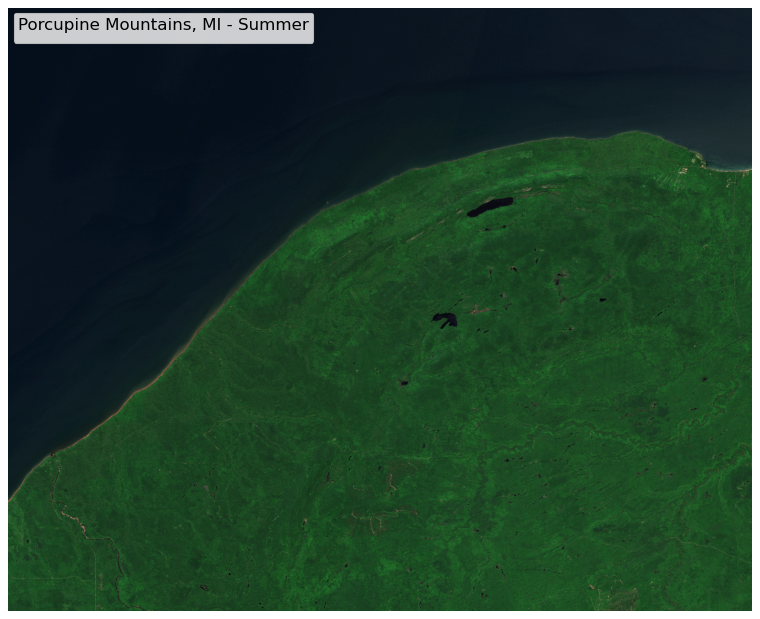

In [30]:
#Visualize the image
#factor is used to highlight or brighten the image - often raw radiance values are dull to our eyes
factor = 5

#Get every pixel into a 0-1 range
normalized_img = np.clip(data[0]*factor/255, 0, 1)
plt.figure(num=None, figsize=(12,12), dpi = 80)
plt.axis('off')

#add a title with a legend box
plt.legend(title = "Porcupine Mountains, MI - Summer", loc = 2, title_fontsize = 15, fancybox = True)
plt.imshow(normalized_img)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


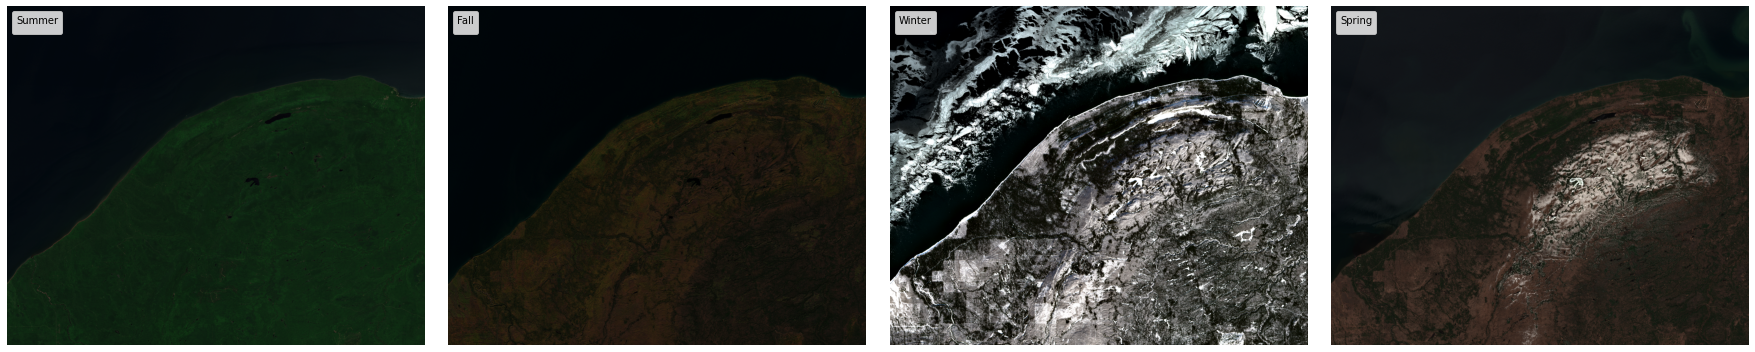

In [34]:
# Set columns and rows for images
ncols = 4
nrows = 1
aspect_ratio = aoi_size[0] / aoi_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

#titles for the plots
seasons_list = ['Summer','Fall','Winter','Spring']

#plot the different seasons
for idx, image in enumerate(data):
    ax = axs[idx]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.legend(title = seasons_list[idx],loc = 2, title_fontsize=10)

plt.tight_layout()

In [313]:
#Collect only png's from the data folder
image_list = [file for file in os.listdir("../Data/") if file.split(".")[1] == "png"]

#Reorder the list to be seasonal (summer, fall, winter, spring)
my_order = [2,0,3,1]
seasons_list = [image_list[index] for index in my_order]
seasons_list

['porcupine_summer.png',
 'porcupine_fall.png',
 'porcupine_winter.png',
 'porcupine_spring.png']

In [315]:
#Create the gif
import imageio
images = []

#Load each image into imageio and then create a gif from the loaded images
for filename in seasons_list:
    images.append(imageio.imread("../Data/" + filename))
imageio.mimsave("../Data/" + 'porcupine_seasons.gif', images, duration=1)

c:\Users\wjeer\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys
